# Implement Dynamic Time Warping Baseline

https://tslearn.readthedocs.io/en/stable/variablelength.html#clustering

https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html#clustering

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pickle

def clean_plot():
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)    
    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()   
    plt.grid()

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import adjusted_rand_score

In [17]:
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# torch.manual_seed(0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


from pyro.distributions import MultivariateNormal, Normal, Independent

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score

import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

import sys
sys.path.append('../model/')
from utils import check_has_missing, quad_function, convert_XY_pack_pad

sys.path.append('../evaluation/')
from eval_utils import get_cluster_swap_metric, get_cluster_pear_metric

sys.path.append('../plot/')
from plot_utils import plot_latent_labels, plot_delta_comp

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
# 'figure.figsize': (10,6),
 'axes.labelsize': 'x-large',
 'axes.titlesize':'x-large',
 'xtick.labelsize':'x-large',
 'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def get_hyperparameters(data_format_num):
    if data_format_num < 3:
        C, ds, dh, drnn, reg_type, lr = 0., 10, 20, 50, 'l1', 0.01
    if data_format_num > 2:
        C, ds, dh, drnn, reg_type, lr = 0., 20, 50, 100, 'l1', 0.01
    if data_format_num == 5 or data_format_num == 3:
        C, ds, dh, drnn, reg_type, lr = 0.01, 20, 20, 100, 'l2', 0.01
    if data_format_num == 1:
        C, ds, dh, drnn, reg_type, lr = 0.0, 20, 30, 150, 'l1', 0.001
    return C, ds, dh, drnn, reg_type, lr


sys.path.append('../model')
from models import Sublign


In [18]:
import argparse
import os
import sys
sys.path.append('../data')
sys.path.append('../plot')
from load import sigmoid, quadratic, chf, parkinsons, load_data_format, load_synthetic_data, load_sigmoid_data
from data_utils import parse_data, change_missing
from plot_utils import plot_subtypes, plot_latent

data_format_num = 11

max_visits      = 17
num_output_dims = 3
use_sigmoid     = True
epochs          = 100

# Change configurations here

# DOES NOT work
# C, ds, dh, drnn, reg_type, lr = 0.0, 20, 30, 150, 'l1', 0.1

# DOES work
C, ds, dh, drnn, reg_type, lr = 0.0, 20, 30, 150, 'l1', 0.001

configs = (C, ds, dh, drnn, reg_type, lr)
data    = load_data_format(data_format_num, trial_num=0, cache=True)
shuffle = False

train_data_loader, train_data_dict, _, _, test_data_loader, test_data_dict, valid_pid, test_pid, unique_pid = parse_data(data.values, 
                                                                                                                         max_visits=max_visits, 
                                                                                                                         test_per=0.2, valid_per=0.2, 
                                                                                                                         shuffle=shuffle)
data_loader, collect_dict, unique_pid = parse_data(data.values, max_visits=max_visits)

# model = Sublign(ds, dh, drnn, C, num_output_dims, sigmoid=use_sigmoid, reg_type=reg_type, auto_delta=False, 
#                 max_delta=5, learn_time=True)

# model.fit(train_data_loader, test_data_loader, epochs, lr, verbose=False, 
#           fname='data%d.pt' % (data_format_num), eval_freq=25, epoch_debug=False, 
#           plot_debug=False)


# subtypes = model.get_subtypes(train_data_dict['obs_t_collect'], train_data_dict['Y_collect'], K=2)
# train_results = model.score(train_data_dict, train_data_dict)
# test_results  = model.score(train_data_dict, test_data_dict)

# train_ari, train_swaps, train_pear = train_results['ari'], train_results['swaps'], train_results['pear']
# test_ari, test_swaps, test_pear    = test_results['ari'], test_results['swaps'], test_results['pear']

# Y = test_data_dict['Y_collect']
# X = test_data_dict['obs_t_collect']
# M = test_data_dict['mask_collect']
# S = None

# nelbo, nll, kl = model.get_loss(Y, S, X, M, anneal=1.)
# # log_p = model.imp_sampling(X,Y,imp_samples=10)

# # print ('Test NELBO:',nelbo.mean(), 'test log_p:',log_p)
# nelbo, nll, kl = nelbo.mean().detach().numpy(), nll.mean().detach().numpy(), kl.mean().detach().numpy()

# print('Train: ARI (up): %.3f, Swaps (down): %.3f, Pear (up): %.3f' % (train_ari, train_swaps, train_pear))
# print('Test: ARI (up): %.3f, Swaps (down): %.3f, Pear (up): %.3f' % (test_ari, test_swaps, test_pear))
# print('Test NELBO: %.3f, Test NLL: %.3f, Test KL: %.3f' % (nelbo, nll, kl))

Max visits: 17
Max visits: 17


## Bring in dynamic time warping!

In [4]:
import sys
sys.path.append('../model')
from utils import interpolate

In [24]:
%%time

# for trial_num in range(5):
data_format_num = 12
trial_num = 1

results = []

for trial_num in range(1,6):
    data    = load_data_format(data_format_num, trial_num=trial_num)
    shuffle = False

    train_data_loader, train_data_dict, _, _, test_data_loader, test_data_dict, valid_pid, test_pid, unique_pid = parse_data(data.values, 
                                                                                                                             max_visits=max_visits, 
                                                                                                                             test_per=0.2, valid_per=0.2, 
                                                                                                                             shuffle=shuffle)

    km = KernelKMeans(n_clusters=2)
    metric = 'softdtw'
    how_impute = 'mrnn'

    km = TimeSeriesKMeans(n_clusters=2, metric=metric)

    X_train = train_data_dict['Y_collect']
    X_test  = test_data_dict['Y_collect']

    M_train = train_data_dict['mask_collect']
    T_train = train_data_dict['obs_t_collect']
    
    M_test  = test_data_dict['mask_collect']
    T_test  = test_data_dict['obs_t_collect']
    
#     if data_format_num == 11 or data_format_num == 12:
#         X_train = interpolate(X_train, m=M_train, t=T_train, how=how_impute)
#         X_test  = interpolate(X_test, m=M_test, t=T_test, how=how_impute)

    X_train = np.concatenate([X_train,train_data_dict['obs_t_collect']],axis=2)

    y_train = train_data_dict['s_collect']

    X_test = np.concatenate([X_test,test_data_dict['obs_t_collect']],axis=2)
    y_test = test_data_dict['s_collect']

    km.fit(X_train)
    labels_test = km.predict(X_test)

    test_ari = adjusted_rand_score(np.squeeze(y_test), labels_test)
    print('Test ARI: %.4f' % test_ari)
    results.append(test_ari)

print('Data %d, %s, %s: %.3f $\\pm$ %.3f' % (data_format_num, metric, how_impute, np.mean(results), np.std(results)))

Max visits: 17
Test ARI: -0.0046
Max visits: 17
Test ARI: -0.0027
Max visits: 17
Test ARI: -0.0041
Max visits: 17
Test ARI: -0.0012
Max visits: 17
Test ARI: -0.0045
Data 12, softdtw, mrnn: -0.003 $\pm$ 0.001
CPU times: user 3min 55s, sys: 0 ns, total: 3min 55s
Wall time: 3min 55s


In [25]:
results = np.array([[0.960, 0.098, 0.457],
 [0.980, -0.096, 0.535],
 [1.000, 0.170, 0.447 ]])

In [ ]:
for i, j in zip(results.mean(axis=0), results.std(axis=0)):
    print('%.3f $\\pm$ %.3f' % (i,j),)

In [10]:
np.isnan(X_train).any()

False

In [15]:
def fill_nan_with_mean(a):
    a[a == -1000] = None
    return np.where(np.isnan(a), np.ma.array(a, mask=np.isnan(a)).mean(axis=0), a)

In [14]:
fill_nan_with_mean(X_train)

array([[[0.16253184, 0.        , 0.26507077, 0.        ],
        [0.        , 0.59005374, 0.        , 0.10735513],
        [0.        , 0.61319411, 0.46133272, 1.03194413],
        ...,
        [1.        , 0.81249583, 0.74398664, 7.78348463],
        [1.        , 0.80300581, 0.78064201, 8.35843784],
        [1.        , 0.82061124, 0.79688799, 8.86198941]],

       [[0.30806365, 0.36336766, 0.26507077, 0.        ],
        [0.93187958, 0.47935769, 0.32315527, 0.58865661],
        [0.41631457, 0.61319411, 0.6996029 , 2.16676378],
        ...,
        [0.77791268, 1.        , 0.6111334 , 6.33726501],
        [0.79606168, 1.        , 0.78064201, 8.35843784],
        [0.78403856, 0.82061124, 0.89394498, 8.41668701]],

       [[0.30806365, 0.36336766, 0.08252822, 0.        ],
        [1.        , 0.47935769, 0.32315527, 0.58865661],
        [0.41631457, 0.8819344 , 0.46133272, 1.03194413],
        ...,
        [0.77791268, 0.81249583, 0.74398664, 7.78348463],
        [0.79606168, 1.      

In [7]:
# kmeans_mean = np.mean([0.2072, 0.0176, 0.0629, -0.0016, 0.0313])
# kmeans_std = np.std([0.2072, 0.0176, 0.0629, -0.0016, 0.0313])

# print('Kernel KMeans %.2f $\\pm$ %.2f' % (kmeans_mean, kmeans_std))

In [8]:
np.linspace(3,100,20)

array([  3.        ,   8.10526316,  13.21052632,  18.31578947,
        23.42105263,  28.52631579,  33.63157895,  38.73684211,
        43.84210526,  48.94736842,  54.05263158,  59.15789474,
        64.26315789,  69.36842105,  74.47368421,  79.57894737,
        84.68421053,  89.78947368,  94.89473684, 100.        ])

In [9]:
np.zeros(20)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [4]:
# time series kmeans
import time

start = time.time()

# for trial_num in range(5):
trial_num = 0
epochs          = 1000

N_visit_options = [2,4,6,8,10,12,14,16,18,20]
results_data = np.zeros((len(N_visit_options), 4))

for visits_ix, N_visits_float in enumerate(N_visit_options):
    end = time.time()
    print(visits_ix,end - start)
    
    N_visits = int(N_visits_float)

    
    data = load_sigmoid_data(subtypes=2, F=3, N=1000, M=N_visits, noise=0.25)
    # data    = load_data_format(data_format_num, trial_num=trial_num, cache=True)
    shuffle = False

    train_data_loader, train_data_dict, _, _, test_data_loader, test_data_dict, valid_pid, test_pid, unique_pid = parse_data(data.values, 
                                                                                                                           max_visits=N_visits, 
                                                                                                                             test_per=0.2, valid_per=0.2, 
                                                                                                                           shuffle=shuffle)
    
    model = Sublign(ds, dh, drnn, C, num_output_dims, sigmoid=use_sigmoid, reg_type=reg_type, auto_delta=False, 
                max_delta=5, learn_time=True)

    model.fit(train_data_loader, test_data_loader, epochs, lr, verbose=False, 
              fname='data%d.pt' % (data_format_num), eval_freq=25, epoch_debug=False, 
              plot_debug=False)


    subtypes = model.get_subtypes(train_data_dict['obs_t_collect'], train_data_dict['Y_collect'], K=2)
#     train_results = model.score(train_data_dict, train_data_dict)
    test_results  = model.score(train_data_dict, test_data_dict)
    results_data[visits_ix,3] = test_results['ari']
    
    for metric_num, metric in enumerate(['softdtw', 'dtw', 'euclidean']):

        km = TimeSeriesKMeans(n_clusters=2, metric=metric)

        X_train = np.concatenate([train_data_dict['Y_collect'],train_data_dict['obs_t_collect']],axis=2)
        y_train = train_data_dict['s_collect']

        X_test = np.concatenate([test_data_dict['Y_collect'],test_data_dict['obs_t_collect']],axis=2)
        y_test = test_data_dict['s_collect']

        km.fit(X_train)
        labels_test = km.predict(X_test)

        test_ari = adjusted_rand_score(np.squeeze(y_test), labels_test)
#         print('Test (%s) ARI: %.4f' % (metric, test_ari))
        results_data[visits_ix,metric_num] = test_ari

NameError: name 'np' is not defined

In [32]:
N_visit_options

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [33]:
clean_plot()
# xs_short = np.linspace(3,100,15)

xs = N_visit_options

# for i in range(15):
#     xs[i] = xs_short[i]

for metric_num, metric in enumerate(['softdtw', 'dtw', 'euclidean', 'sublign']):
    ys = results_data[:,metric_num]
    plt.plot(xs[:7], ys[:7], label=metric)

plt.xlabel('Visits Per Person')
plt.ylabel('Held-out Cluster Performance (ARI)')
plt.legend()
plt.show()

In [13]:
kmeans_mean = np.mean([0.0205, 0.0072, 0.0050, -0.0046, -0.0025])
kmeans_std = np.std([0.0205, 0.0072, 0.0050, -0.0046, -0.0025])

print('%.4f $\\pm$ %.2f' % (kmeans_mean, kmeans_std))

0.0051 $\pm$ 0.01


In [37]:
labels_test.shape

(200,)

## Compare for higher percentage of missingness

In [ ]:
data = load_data_format(13, trial_num=1)
    
train_data_loader, train_data_dict, _, _, test_data_loader, test_data_dict, valid_pid, test_pid, unique_pid = parse_data(data.values, 
                                                                                                                     max_visits=max_visits, 
                                                                                                                     test_per=0.2, valid_per=0.2, 
                                                                                                                     shuffle=False)

# X = train_data_dict['obs_t_collect']
# Y = train_data_dict['Y_collect']
# M = train_data_dict['mask_collect']

# X[X == -1000] = np.nan
# Y[Y == -1000] = np.nan

# sys.path.append('../model')
# from utils import interpolate

# Y_linear = interpolate(Y, how='linear')
# Y_mice = interpolate(Y, how='mice')

# # Y_mrnn = interpolate(Y, M, X, how='mrnn')


In [13]:
# time series kmeans
import time

start = time.time()

# for trial_num in range(5):
trial_num = 0
epochs          = 1000

# N_visit_options = [2,4,6,8,10,12,14,16,18,20]
N_visit_options = [1,1,1,1]
results_data = np.zeros((len(N_visit_options), 4))

for visits_ix, N_visits_float in enumerate(N_visit_options):
    end = time.time()
    print(visits_ix,end - start)
    
    N_visits = int(N_visits_float)

    
#     data = load_sigmoid_data(subtypes=2, F=3, N=1000, M=N_visits, noise=0.25)
    data    = load_data_format(data_format_num=11, trial_num=trial_num, cache=True)
    shuffle = False

    train_data_loader, train_data_dict, _, _, test_data_loader, test_data_dict, valid_pid, test_pid, unique_pid = parse_data(data.values, 
                                                                                                                           max_visits=N_visits, 
                                                                                                                             test_per=0.2, valid_per=0.2, 
                                                                                                                           shuffle=shuffle)
    
#     model = Sublign(ds, dh, drnn, C, num_output_dims, sigmoid=use_sigmoid, reg_type=reg_type, auto_delta=False, 
#                 max_delta=10, learn_time=True)

#     model.fit(train_data_loader, test_data_loader, epochs, lr, verbose=False, 
#               fname='data%d.pt' % (data_format_num), eval_freq=25, epoch_debug=False, 
#               plot_debug=False)


#     subtypes = model.get_subtypes(train_data_dict['obs_t_collect'], train_data_dict['Y_collect'], K=2)
# #     train_results = model.score(train_data_dict, train_data_dict)
#     test_results  = model.score(train_data_dict, test_data_dict)
#     results_data[visits_ix,3] = test_results['ari']
    
    for metric_num, metric in enumerate(['softdtw', 'dtw', 'euclidean']):

        km = TimeSeriesKMeans(n_clusters=2, metric=metric)

        
        X_train = np.concatenate([train_data_dict['Y_collect'],train_data_dict['obs_t_collect']],axis=2)
        y_train = train_data_dict['s_collect']

        X_test = np.concatenate([test_data_dict['Y_collect'],test_data_dict['obs_t_collect']],axis=2)
        y_test = test_data_dict['s_collect']

        
#         X_train = interpolate(X_train, how='mice')
#         X_test = interpolate(X_test, how='mice')

        km.fit(X_train)
        labels_test = km.predict(X_test)

        test_ari = adjusted_rand_score(np.squeeze(y_test), labels_test)
#         print('Test (%s) ARI: %.4f' % (metric, test_ari))
        results_data[visits_ix,metric_num] = test_ari

0 0.0007536411285400391
Max visits: 17
1 83.24918842315674
Max visits: 17
2 155.33066272735596
Max visits: 17
3 215.73594546318054
Max visits: 17


In [15]:
results_data

array([[-1.73293418e-03, -3.43939365e-03, -4.10614019e-03,
         0.00000000e+00],
       [-9.04614538e-05,  4.64162504e-05, -3.42361258e-03,
         0.00000000e+00],
       [-4.60237461e-03, -4.61601241e-03, -4.12074501e-03,
         0.00000000e+00],
       [-2.45231594e-03, -4.78970052e-03, -4.40718363e-03,
         0.00000000e+00]])

In [8]:
y_train.shape

(600, 1)

## PPMI DTW results?

In [16]:
sys.path.append('../data')
from load import parkinsons

In [17]:
# time series kmeans
import time

start = time.time()

# for trial_num in range(5):
trial_num = 0
epochs          = 1000

# N_visit_options = [2,4,6,8,10,12,14,16,18,20]
N_visit_options = [1,1,1,1]
results_data = np.zeros((len(N_visit_options), 4))

data = parkinsons()
shuffle = False

train_data_loader, train_data_dict, _, _, test_data_loader, test_data_dict, valid_pid, test_pid, unique_pid = parse_data(data.values, 
                                                                                                                       max_visits=N_visits, 
                                                                                                                         test_per=0.2, valid_per=0.2, 
                                                                                                                       shuffle=shuffle)


for visits_ix, N_visits_float in enumerate(N_visit_options):
    end = time.time()
    print(visits_ix,end - start)
    
    N_visits = int(N_visits_float)

    
#     data = load_sigmoid_data(subtypes=2, F=3, N=1000, M=N_visits, noise=0.25)
#     data    = load_data_format(data_format_num=11, trial_num=trial_num, cache=True)
    
#     model = Sublign(ds, dh, drnn, C, num_output_dims, sigmoid=use_sigmoid, reg_type=reg_type, auto_delta=False, 
#                 max_delta=10, learn_time=True)

#     model.fit(train_data_loader, test_data_loader, epochs, lr, verbose=False, 
#               fname='data%d.pt' % (data_format_num), eval_freq=25, epoch_debug=False, 
#               plot_debug=False)


#     subtypes = model.get_subtypes(train_data_dict['obs_t_collect'], train_data_dict['Y_collect'], K=2)
# #     train_results = model.score(train_data_dict, train_data_dict)
#     test_results  = model.score(train_data_dict, test_data_dict)
#     results_data[visits_ix,3] = test_results['ari']
    
    for metric_num, metric in enumerate(['softdtw', 'dtw', 'euclidean']):

        km = TimeSeriesKMeans(n_clusters=2, metric=metric)

        
        X_train = np.concatenate([train_data_dict['Y_collect'],train_data_dict['obs_t_collect']],axis=2)
        y_train = train_data_dict['s_collect']

        X_test = np.concatenate([test_data_dict['Y_collect'],test_data_dict['obs_t_collect']],axis=2)
        y_test = test_data_dict['s_collect']

        
#         X_train = interpolate(X_train, how='mice')
#         X_test = interpolate(X_test, how='mice')

        km.fit(X_train)
        labels_test = km.predict(X_test)

        test_ari = adjusted_rand_score(np.squeeze(y_test), labels_test)
#         print('Test (%s) ARI: %.4f' % (metric, test_ari))
        results_data[visits_ix,metric_num] = test_ari
print(results_data)

0 0.0006690025329589844
loading PPMI data
Max visits: 17
1 14.215641498565674
loading PPMI data
Max visits: 17
2 31.361016511917114
loading PPMI data
Max visits: 17
3 54.46832513809204
loading PPMI data
Max visits: 17
[[ 0.61361457  0.93526411 -0.0063914   0.        ]
 [ 0.72440539  0.03855642 -0.0063914   0.        ]
 [ 0.93526411  0.93526411 -0.00500452  0.        ]
 [ 0.06151802  0.93526411 -0.00730538  0.        ]]


## Run DTW that works

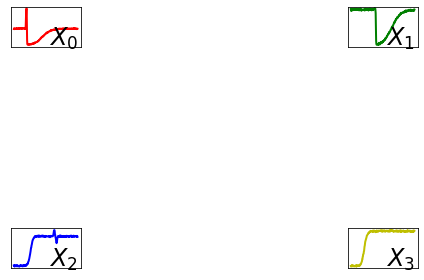

In [14]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.colors

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.barycenters import softdtw_barycenter
from tslearn.datasets import CachedDatasets


def row_col(position, n_cols=5):
    idx_row = (position - 1) // n_cols
    idx_col = position - n_cols * idx_row - 1
    return idx_row, idx_col


def get_color(weights):
    baselines = numpy.zeros((4, 3))
    weights = numpy.array(weights).reshape(1, 4)
    for i, c in enumerate(["r", "g", "b", "y"]):
        baselines[i] = matplotlib.colors.ColorConverter().to_rgb(c)
    return numpy.dot(weights, baselines).ravel()


numpy.random.seed(0)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_out = numpy.empty((4, X_train.shape[1], X_train.shape[2]))

plt.figure()
for i in range(4):
    X_out[i] = X_train[y_train == (i + 1)][0]
X_out = TimeSeriesScalerMinMax().fit_transform(X_out)

for i, pos in enumerate([1, 5, 21, 25]):
    plt.subplot(5, 5, pos)
    w = [0.] * 4
    w[i] = 1.
    plt.plot(X_out[i].ravel(),
             color=matplotlib.colors.rgb2hex(get_color(w)),
             linewidth=2)
    plt.text(X_out[i].shape[0], 0., "$X_%d$" % i,
             horizontalalignment="right",
             verticalalignment="baseline",
             fontsize=24)
    plt.xticks([])
    plt.yticks([])

# for pos in range(2, 25):
#     if pos in [1, 5, 21, 25]:
#         continue
#     plt.subplot(5, 5, pos)
#     idxr, idxc = row_col(pos, 5)
#     w = numpy.array([0.] * 4)
#     w[0] = (4 - idxr) * (4 - idxc) / 16
#     w[1] = (4 - idxr) * idxc / 16
#     w[2] = idxr * (4 - idxc) / 16
#     w[3] = idxr * idxc / 16
#     plt.plot(softdtw_barycenter(X=X_out, weights=w).ravel(),
#              color=matplotlib.colors.rgb2hex(get_color(w)),
#              linewidth=2)
#     plt.xticks([])
#     plt.yticks([])


plt.tight_layout()
plt.show()


In [13]:
X_out.shape

(4, 275, 1)

In [6]:
y_train.shape

(100,)

In [7]:
REDACTED = softdtw_barycenter(X=X_out, weights=w).ravel()

In [9]:
REDACTED.shape

(275,)